## A fastai Callback class to plot GPU Utilization during training.

It starts the `nvidia-smi stats` process and tails it's output. To make it as lightweight as possible it only updates the plot once it collects the configured amount of samples and doesn't start new Python threads, instead it uses [select](https://docs.python.org/3/library/select.html) to monitor for new samples.

It monitors GPU with the index taken from the `Datasets.device` used by the `Learner`

In [ ]:
import select
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import fastprogress
from fastai2.callback.all import *

class GpuUtilization(Callback):
    
    def __init__(self, figsize=(10,4), draw_every=50):
        self.figsize = figsize
        self.draw_every = draw_every
    
    def begin_fit(self):
        if not fastprogress.core.in_notebook():
            warn('GpuUtilization is meant to be run in a Jupyter notebook environment')
            return
        if self.learn.dls.device.type != 'cuda':
            warn(f'GpuUtilization expected cuda device, got {self.learn.dls.device.type}')
            return
        self.samples = []
        self.samples_drawn = 0
        command = ['nvidia-smi', 'stats', 
                   '-d', 'gpuUtil',
                   '-i', str(self.learn.dls.device.index)]
        try:
            self.proc = subprocess.Popen(command, stdout=subprocess.PIPE)
            self.poll = select.poll()
            self.poll.register(self.proc.stdout, select.POLLIN)
        except:
            warn('GpuUtilization failed to start nvidia-smi')
            self.proc = None
            
    def after_batch(self):
        self.__read_samples()
        if len(self.samples) - self.samples_drawn > self.draw_every:
            self.update_graph()


    def after_fit(self):
        if hasattr(self, 'proc'): 
            self.poll.unregister(self.proc.stdout)
            self.proc.terminate()
        del self.graph_ax
            
    def after_train(self):
        self.update_graph()
        
    def after_validate(self):
        self.update_graph()
           
    def __read_samples(self):
        while self.proc and self.poll.poll(1):
            line = self.proc.stdout.readline().decode()
            if not line: break
            t, u = self.__parse_line(line)
            if self.samples and t < self.samples[-1][0]: continue #drop out of order entries
            self.samples.append((t,u))
            
    def __parse_line(self, s):
        # s looks like: '0, gpuUtil , 1588862307216262, 50\n'
        parts = s.replace(',',' ').split()
        return int(parts[2]), int(parts[3])
    
    def update_graph(self):
        if not self.samples: return
        if not hasattr(self, 'graph_ax'):
            graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
            plt.close()
            self.graph_out = display(self.graph_ax.figure, display_id=True)

        self.graph_ax.clear()
        t, u = tuple(zip(*self.samples))
        t = np.array(t)
        t = (t - t[0]) / 1000000 #seconds from the first measurement
        self.graph_ax.plot(t, u)
        self.graph_ax.set_xlabel('time (s)')
        self.graph_ax.set_ylabel('Utilization %')
        self.graph_ax.set_ylim(0,100)
        self.graph_out.update(self.graph_ax.figure)
        self.samples_drawn = len(self.samples)

## Example 1

Trains resnet18 on the MNIST dataset, `GpuUtilization` is passed as the `Learner` as a callback. The plot is updated either after collecting 50 samples (roughly 10 seconds) or at the end of an epoch.

In [5]:
from fastai2.vision.all import *
path = untar_data(URLs.MNIST_SAMPLE)

dls = ImageDataLoaders.from_folder(path)

learn = cnn_learner(dls, resnet18, metrics=accuracy, cbs=GpuUtilization)

epoch,train_loss,valid_loss,accuracy,time
0,0.231192,0.087434,0.973503,00:08
1,0.073631,0.042579,0.984789,00:07
2,0.042886,0.031326,0.988224,00:06
3,0.026846,0.029926,0.989205,00:06


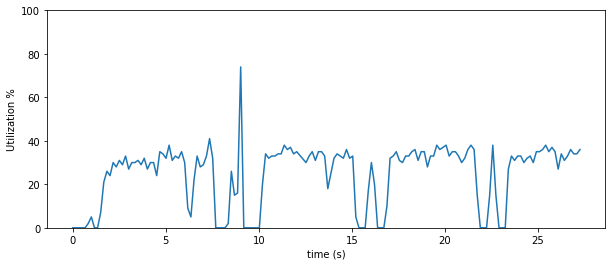

CPU times: user 21.3 s, sys: 3.68 s, total: 25 s
Wall time: 28.5 s


In [6]:
learn.fit_one_cycle(4)

## Example 2

Passing `draw_ever` parameter to change how often the graph is redrawn. Note that it might affect the result as drawing takes time during which GPU is idle.

epoch,train_loss,valid_loss,accuracy,time
0,0.158110,0.080103,0.976938,00:08
1,0.071305,0.061111,0.981845,00:06


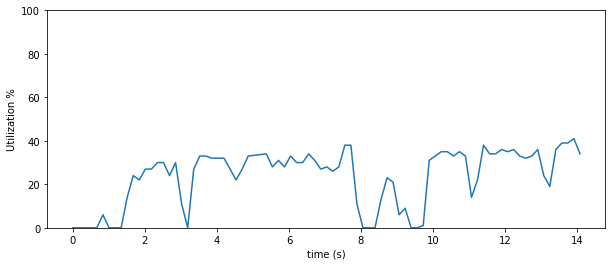

In [8]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, cbs=GpuUtilization(draw_every=10))
learn.fit_one_cycle(2)

## Example 3

Passing `figsize` parameter to make the chart larger.

epoch,train_loss,valid_loss,accuracy,time
0,0.159809,0.061967,0.977920,00:08
1,0.075439,0.044224,0.984298,00:06


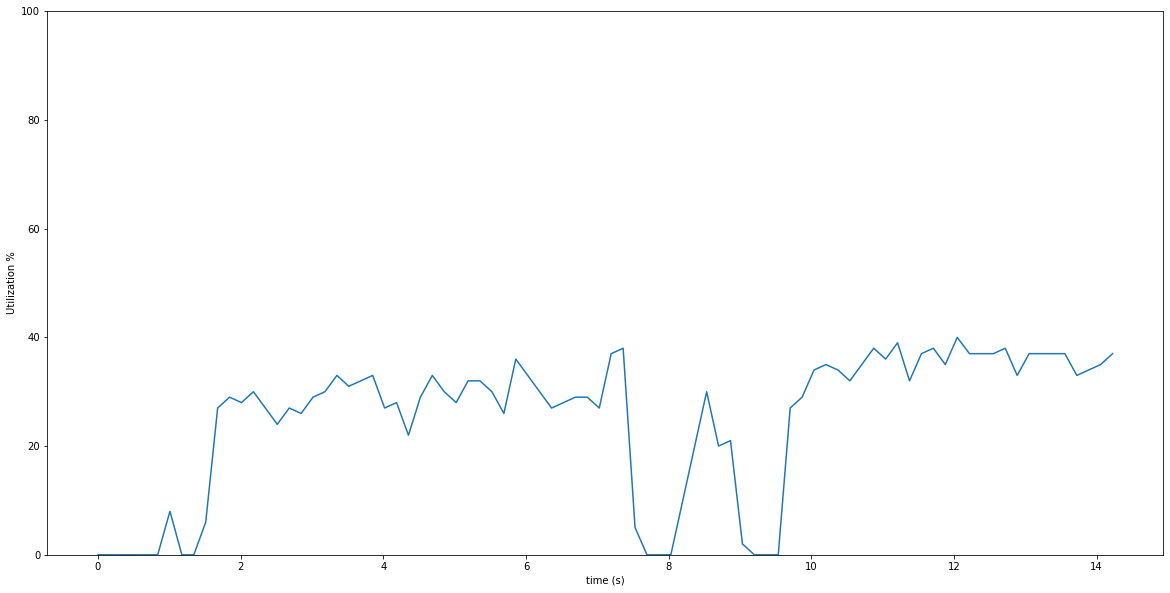

In [10]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, cbs=GpuUtilization(figsize=(20,10)))
learn.fit_one_cycle(2)

## Example 4

You can use this and `ShowGraphCallback` at the same time, it uses a separate plot

epoch,train_loss,valid_loss,accuracy,time
0,0.169186,0.072169,0.976448,00:08
1,0.071656,0.058153,0.981845,00:06


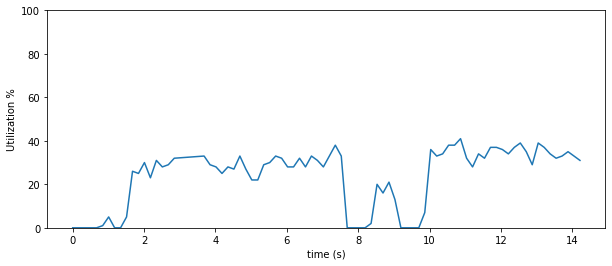

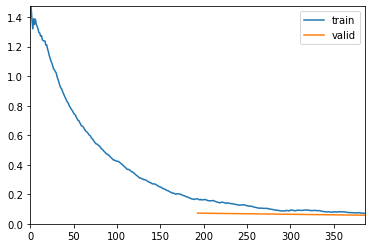

In [11]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, cbs=[GpuUtilization, ShowGraphCallback])
learn.fit_one_cycle(2)